In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as t
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy
from tensorflow.compat.v1.ragged import RaggedTensorValue

In [3]:
IMAGE_SIZE=128
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50 # its a trail and error

In [4]:
#loading data from google drive
dataset=t.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tomato Dataset",
    shuffle=True,
    image_size=( IMAGE_SIZE,IMAGE_SIZE),
     batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
#set the names according to the classes in Data
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
# checking the length of Data
#each batch contain 32 images 32*501 =(near to the 16011)
len(dataset)

501

In [7]:
#checking the imges
#32 images in 1 batch
#128 x and y
# 3 is RGB
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 128, 128, 3)
[7 4 5 2 4 5 7 3 2 8 7 0 4 0 2 7 9 7 7 1 4 3 0 5 9 8 0 2 7 3 2 0]


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)


(128, 128, 3)


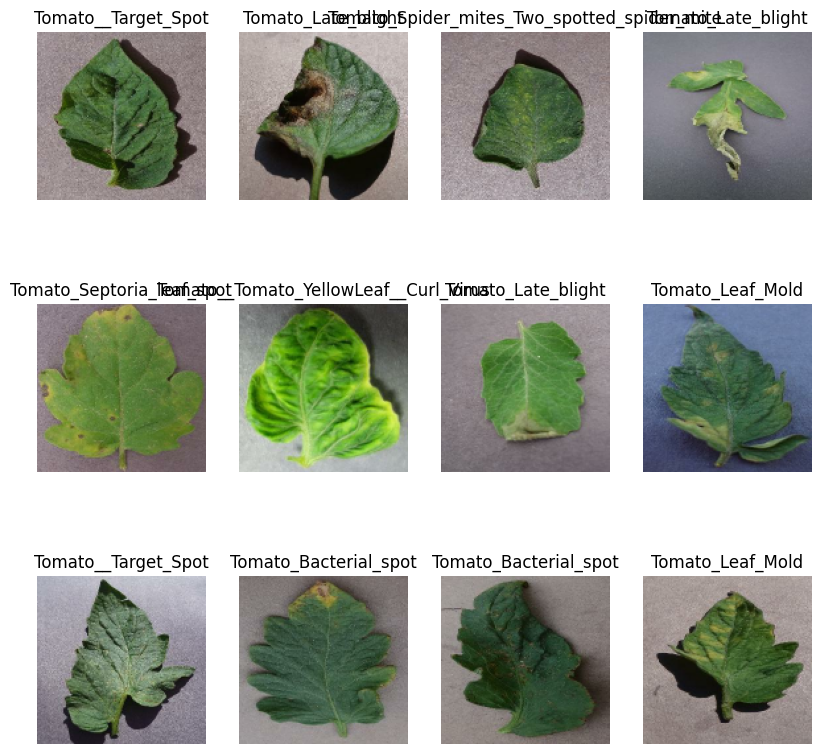

In [9]:
 # for every run of the current cell image will shuffle,used shuffle function at the loading of the data
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [10]:
## split the Data into 80% for taining
                      #10% for testing
                      #10% for validation

In [11]:
train_size=0.8
len(dataset)*train_size

400.8

In [12]:
train_ds=dataset.take(400)
len(train_ds)

400

In [13]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [14]:
val_size=0.1
len(dataset)*val_size

50.1

In [15]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [16]:
test_ds=test_ds.skip(50)
len(test_ds)

51

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [18]:
#assigning the data to the test,validation,train
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [19]:
# checking the data split

In [20]:
len(train_ds)

400

In [21]:
len(val_ds)

50

In [22]:
len(test_ds)

51

In [23]:
#elements of the dataset in memory after they are loaded from disk or any other data source.
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)

In [24]:
# scalling reduce the computing power on the model
resize_and_rescale=t.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
# Training a model using randomflip and random rotation to perform better
# if it is roatated images in a test data
data_augmentation=t.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
#input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
#n_classes =10

#model=models.Sequential([
 #   resize_and_rescale,
  #  data_augmentation,
   ## layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Flatten(),
    #layers.Dense(64,activation='relu'),
    #layers.Dense(n_classes,activation='softmax')
#])

#model.build(input_shape=input_shape)

In [27]:
#input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
#n_classes =10

#model=models.Sequential([
 #   resize_and_rescale,
 #   data_augmentation,
  #  layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
  #  layers.MaxPooling2D((2,2)),

   # layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
   # layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Conv2D(64,(3,3),activation='relu'),
    #layers.MaxPooling2D((2,2)),

    #layers.Flatten(),
    #layers.Dense(64,activation='relu'),
    #layers.Dense(n_classes,activation='softmax')])

#model.build(input_shape=input_shape)

In [28]:
#BATCH_SIZE = 32
#IMAGE_SIZE = 64  # Adjust this as needed
#CHANNELS = 3  # Assuming RGB images
#n_classes = 10

#model = models.Sequential([
#    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
#    layers.MaxPooling2D((2, 2)),

#    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#    layers.MaxPooling2D((2, 2)),

 #   layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
 #   layers.MaxPooling2D((2, 2)),

#    layers.Conv2D(64, (3, 3), activation='relu'),
#    layers.MaxPooling2D((2, 2)),

#    layers.Conv2D(64, (3, 3), activation='relu'),
#    layers.MaxPooling2D((2, 2)),

#    layers.Conv2D(64, (3, 3), activation='relu'),
#    layers.MaxPooling2D((2, 2)),

#    layers.Flatten(),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(n_classes, activation='softmax')])

#model.summary()


In [29]:
from tensorflow.keras import layers, models

BATCH_SIZE = 32
IMAGE_SIZE = 128  # Adjust this as needed
CHANNELS = 3  # Assuming RGB images
n_classes = 10

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)               

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)               

In [31]:
# The model produces probabilities, and the loss function assumes these probabilities are already obtained through a softmax activation.
model.compile(
    optimizer='adam',
    loss=t.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
400/400 [==============================] - 2542s 135ms/step - loss: 19.7664 - accuracy: 0.4318 - val_loss: 1.1383 - val_accuracy: 0.6344
Epoch 2/50
400/400 [==============================] - 6s 15ms/step - loss: 1.1086 - accuracy: 0.6489 - val_loss: 0.8519 - val_accuracy: 0.7294
Epoch 3/50
400/400 [==============================] - 6s 15ms/step - loss: 0.7292 - accuracy: 0.7580 - val_loss: 0.5513 - val_accuracy: 0.8338
Epoch 4/50
400/400 [==============================] - 6s 15ms/step - loss: 0.4295 - accuracy: 0.8548 - val_loss: 0.5799 - val_accuracy: 0.8400
Epoch 5/50
400/400 [==============================] - 6s 15ms/step - loss: 0.3066 - accuracy: 0.8992 - val_loss: 0.4878 - val_accuracy: 0.8781
Epoch 6/50
400/400 [==============================] - 6s 15ms/step - loss: 0.2361 - accuracy: 0.9252 - val_loss: 0.4275 - val_accuracy: 0.9087
Epoch 7/50
400/400 [==============================] - 6s 15ms/step - loss: 0.1845 - accuracy: 0.9415 - val_loss: 0.4363 - val_accuracy: 0

In [33]:
scores=model.evaluate(test_ds)

51/51 [==============================] - 48s 7ms/step - loss: 1.0629 - accuracy: 0.9271


In [34]:
scores

[1.062896728515625, 0.9270833134651184]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
# checking the loss of first 10 epochs
history.history['loss'][:10]

[19.766376495361328,
 1.1085776090621948,
 0.7291713953018188,
 0.42948082089424133,
 0.30658048391342163,
 0.23607350885868073,
 0.18448799848556519,
 0.134071484208107,
 0.20553597807884216,
 0.21177811920642853]

In [39]:
history.history['accuracy']

[0.4317968785762787,
 0.6489062309265137,
 0.7579687237739563,
 0.8548437356948853,
 0.899218738079071,
 0.9252343773841858,
 0.9414843916893005,
 0.9595312476158142,
 0.9424218535423279,
 0.9362499713897705,
 0.9654687643051147,
 0.971484363079071,
 0.9729687571525574,
 0.9731249809265137,
 0.9750000238418579,
 0.9628124833106995,
 0.9702343940734863,
 0.9722656011581421,
 0.977343738079071,
 0.9730468988418579,
 0.9789843559265137,
 0.9728906154632568,
 0.9911718964576721,
 0.9780468940734863,
 0.9784374833106995,
 0.98046875,
 0.9814062714576721,
 0.9694530963897705,
 0.9895312786102295,
 0.9899218678474426,
 0.9826562404632568,
 0.9826562404632568,
 0.986328125,
 0.98828125,
 0.9814062714576721,
 0.9810937643051147,
 0.9884374737739563,
 0.9953906536102295,
 0.9861719012260437,
 0.9700781106948853,
 0.9911718964576721,
 0.9970312714576721,
 0.9974218606948853,
 0.9848437309265137,
 0.9908593893051147,
 0.9917968511581421,
 0.9856250286102295,
 0.9766406416893005,
 0.987265646457672

In [40]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

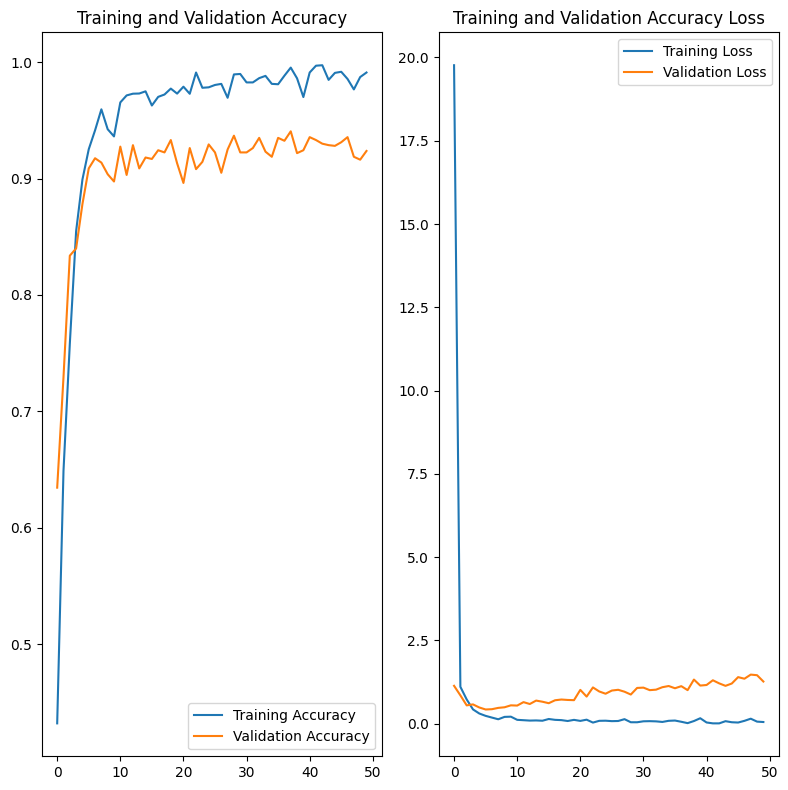

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.tight_layout()
plt.show()

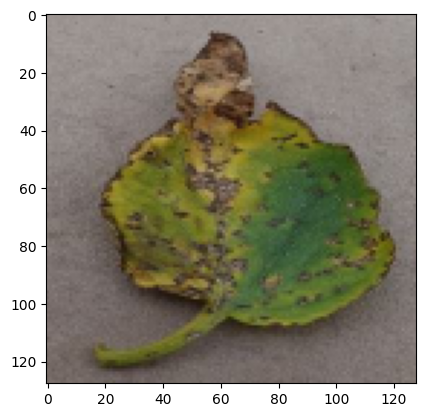

In [42]:
# Run Prediction on a sample
for images_batch,labels_batch in test_ds.take(1):

     plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 185ms/step
[9.9994338e-01 9.2219116e-20 6.9240924e-20 4.0200014e-29 4.9699920e-05
 3.5262285e-28 3.7126449e-24 6.9165922e-06 3.4596389e-33 5.5257718e-24]


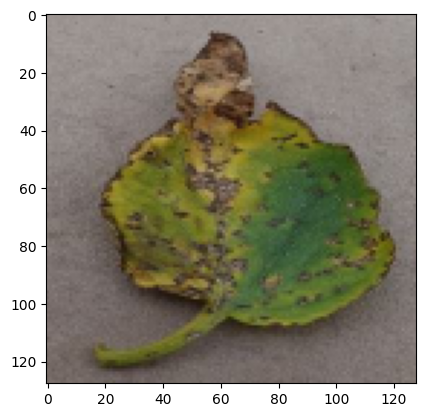

In [43]:
for images_batch,labels_batch in test_ds.take(1):

     first_image=images_batch[0].numpy().astype('uint8')
     first_label=labels_batch[0].numpy()

     print("first image to predict")
     plt.imshow(first_image)

     print("actual label:",class_names[first_label])

     batch_prediction=model.predict(images_batch)
     print(batch_prediction[0])

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 0s 24ms/step
predicted label: Tomato_Septoria_leaf_spot


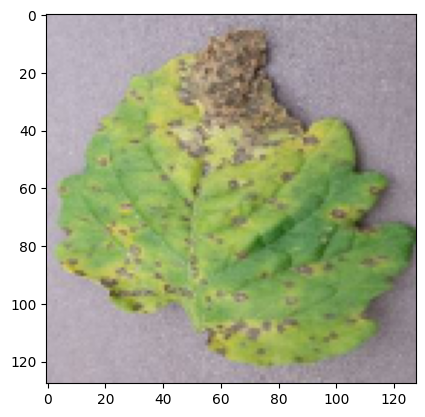

In [45]:
for images_batch,labels_batch in test_ds.take(1):

     first_image=images_batch[0].numpy().astype('uint8')
     first_label=labels_batch[0].numpy()

     print("first image to predict")
     plt.imshow(first_image)
     print("actual label:",class_names[first_label])

     batch_prediction=model.predict(images_batch)
     print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
     img_array = t.keras.preprocessing.image.img_to_array(images[i].numpy())
     img_array = t.expand_dims(img_array, 0) # Create a batch

     predictions = model.predict(img_array)

     predicted_class = class_names[np.argmax(predictions[0])]
     confidence = round(100 *(np.max(predictions[0])), 2)
     return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


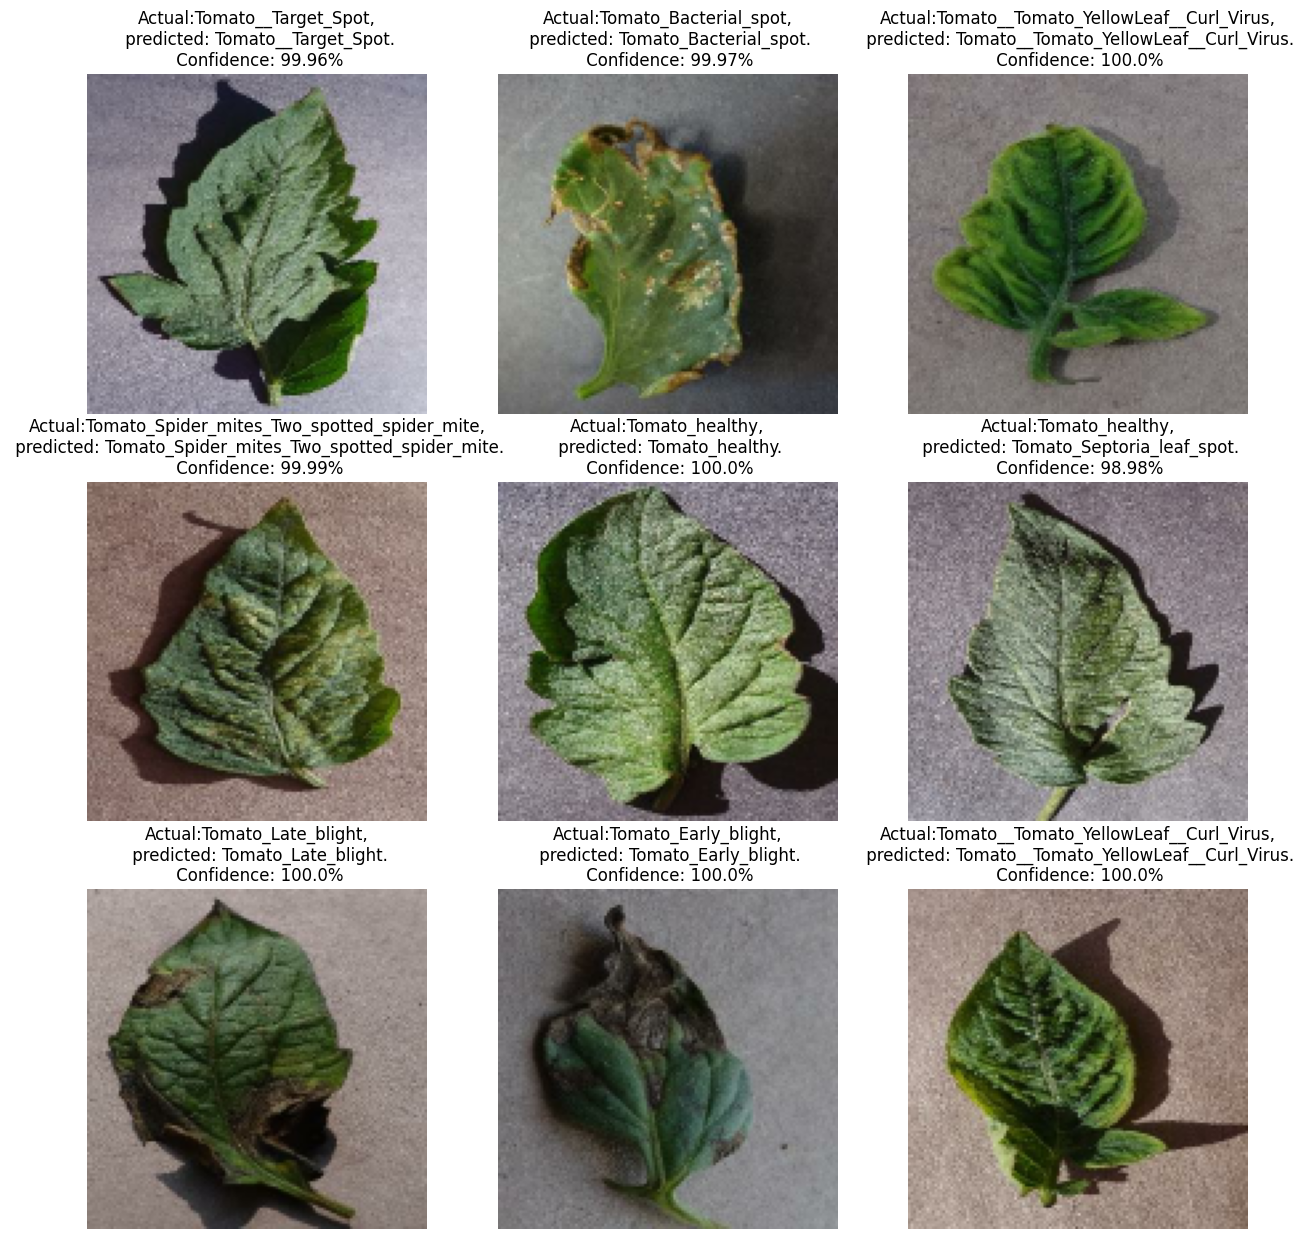

In [47]:
#check the multiple samples how its going to predict
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [48]:
# Save the entire model
model.save('/content/drive/MyDrive/tomato.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
# Save the entire model in the native Keras format
model.save('/content/drive/MyDrive/your_model.keras')
